In [106]:

from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit,transpile, execute,BasicAer
from numpy import pi
from qiskit.circuit import Parameter
import numpy as np
from qiskit.tools.visualization import circuit_drawer,plot_histogram
import matplotlib.pyplot as plt
theta_range = np.linspace(0,  np.pi, 58)

theta = Parameter('θ')

In [107]:
# TABLE I CORRECTIONS 
correct_T = { 1:["z","x"], 2:["x","z"], 3:["xz","xz"], 8:["z","x"], 10:["xz","xz"], 11:["x","z"], 4:["x","z"], 5:["zx","zx"], 7:["z","x"], 12:["zx","zx"], 13:["x","z"], 14:["z","x"] 
        }

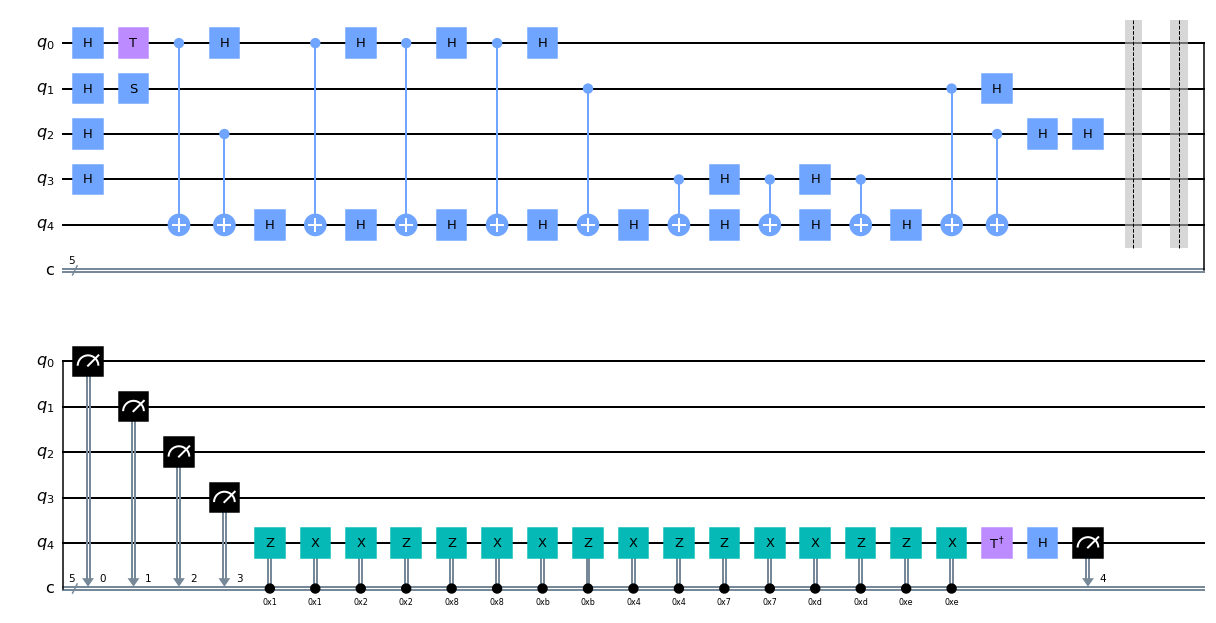

In [118]:
# CIRCUIT BUILDER: we modify the circuit to facilitate the correction procedure
# by shifting qubit 3 to the 5th position, qubit  4 to the 3rd position, and
# qubit 5 to the 4th position.
def Tcircuit(gate, correct):
    qreg_q = QuantumRegister(5, 'q')
    creg_c = ClassicalRegister(5, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    circuit.h(qreg_q[0])
    circuit.h(qreg_q[1])
    circuit.h(qreg_q[2])
    circuit.h(qreg_q[3])
    # T or T^dagger
    if gate == "t":
        circuit.t(qreg_q[0])
    if gate =="dagger":
        circuit.tdg(qreg_q[0])
    circuit.s(qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[4])
    circuit.h(qreg_q[0])
    circuit.cx(qreg_q[2], qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[0], qreg_q[4])
    circuit.h(qreg_q[0])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[0], qreg_q[4])
    circuit.h(qreg_q[0])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[0], qreg_q[4])
    circuit.h(qreg_q[0])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[1], qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[3], qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.h(qreg_q[3])
    circuit.cx(qreg_q[3], qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.h(qreg_q[3])
    circuit.cx(qreg_q[3], qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.cx(qreg_q[1], qreg_q[4])
    circuit.cx(qreg_q[2], qreg_q[4])
    circuit.h(qreg_q[2])

    
    if gate == "t":
        circuit.h(qreg_q[1])
        circuit.h(qreg_q[2])
        circuit.barrier()
    if gate =="dagger":
        circuit.h(qreg_q[0])
        circuit.h(qreg_q[3])
        circuit.barrier()
    circuit.barrier()
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    for correction in correct:
        if gate=="t":
            for c in correct[correction]:
                if c =="z":
                    circuit.z(qreg_q[4]).c_if(creg_c, correction)
                if c == "x":
                    circuit.x(qreg_q[4]).c_if(creg_c, correction)
        if gate =="dagger":
            for c in correct[correction]:
                if c =="z":
                    circuit.z(qreg_q[4]).c_if(creg_c, correction)
                if c == "x":
                    circuit.x(qreg_q[4]).c_if(creg_c, correction)
   
    
    circuit.tdg(qreg_q[4])
    circuit.h(qreg_q[4])
    circuit.measure(qreg_q[4], creg_c[4])
    return circuit

T= Tcircuit("t",correct_T)
T.draw(output='mpl')




In [119]:
def CountsT(circuits):
    simulator = BasicAer.get_backend('qasm_simulator')
    COUNTS=[]
    for i in range(len(circuits)):
        job = simulator.run(transpile(circuits[i], simulator),shots= 8192)
    #測定結果の取り出し
        result = job.result()
        counts = result.get_counts()
        COUNTS.append(counts)
    return COUNTS

In [120]:
Labels= ["t","dagger"]
circuits=[ Tcircuit(label,correct_T) for label in Labels]


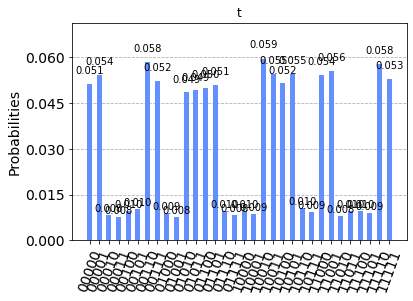

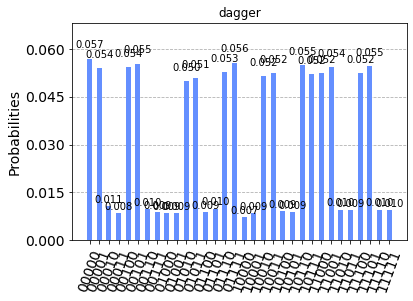

In [121]:
COUNTST= CountsT(circuits)
for i in range(2):
    fig = plt.figure(i)
    plt.plot()
    axs  = fig.get_axes()
    plot_histogram(COUNTST[i],ax =axs[0],title="%s"%(Labels[i]))

In [129]:
def prob(counts):
    correct_counts = []
    for dic in counts:
        answer =0
        val = list(dic.values())
        keys= list(dic.keys())
        for i in range(len(val)):
            L = [int(j)for j in keys[i] ]
            if L[4]%2==0:
                answer+= val[i]

        correct_counts.append(answer)
    return np.array(correct_counts)/8192




In [133]:
# probabilities
prob(COUNTST)

array([0.50537109, 0.49865723])

In [ ]:
# The corrected circuit did not yield the expected results (0 -> 75%).
# This may be due to incorrectly applying Table I Pauli corrections.
# Since the IBM machines can work with more than 5 qubits at the moment,
# there is a high chance that this code can be runned with better results
# than those obtained in the referenced manuscript. Nontheless, since
# dynamic feedforward is not possible at the moment
# (controlled if measurements) there is a high chance 
# of obtaining undesired results. 
